In [50]:
# MoPhones Analysis Script
# ------------------------------------------------------------
# Purpose:
# - Load 2025 point-in-time credit snapshots
# - Enrich with DOB (age bands), Gender, Income (avg per month, income bands)
# - Derive account_status via DPD thresholds
# - Compute portfolio KPIs over time
# - Link NPS responses to nearest credit snapshot per Loan Id
# - Export CSVs and charts to ./outputs


In [51]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook


In [52]:
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)
SNAPSHOTS = [
    ("2025-01-01", "Credit Data - 01-01-2025.csv"),
    ("2025-03-30", "Credit Data - 30-03-2025.csv"),
    ("2025-06-30", "Credit Data - 30-06-2025.csv"),
    ("2025-09-30", "Credit Data - 30-09-2025.csv"),
    ("2025-12-30", "Credit Data - 30-12-2025.csv"),
]
NPS_FILE = "NPS Data.xlsx"
SALES_CUSTOMER_FILE = "Sales and Customer Data.xlsx"


#### HELPER FUNCTIONS

In [53]:
def sheet_to_df(ws):
    """Fast convert openpyxl worksheet to pandas DataFrame (first row = header)."""
    rows = list(ws.iter_rows(values_only=True))
    header = rows[0]
    data = rows[1:]
    return pd.DataFrame(data, columns=header)



In [54]:
def income_band(series: pd.Series) -> pd.Series:
    bins = [-np.inf, 5000, 10000, 20000, 30000, 50000, 100000, 150000, np.inf]
    labels = [
        "Below 5,000",
        "5,000–9,999",
        "10,000–19,999",
        "20,000–29,999",
        "30,000–49,999",
        "50,000–99,999",
        "100,000–149,999",
        "150,000 and above",
    ]
    return pd.cut(series, bins=bins, labels=labels)


In [ ]:
def age_band(age_years: pd.Series) -> pd.Series:
    bins = [0, 18, 26, 36, 46, 56, 200]
    labels = [
        "Below 18 / Invalid",
        "18–25",
        "26–35",
        "36–45",
        "46–55",
        "Above 55",
    ]
    return pd.cut(age_years, bins=bins, labels=labels, right=False)


In [ ]:
def age_band(age_years: pd.Series) -> pd.Series:
    bins = [0, 18, 26, 36, 46, 56, 200]
    labels = [
        "Below 18 / Invalid",
        "18–25",
        "26–35",
        "36–45",
        "46–55",
        "Above 55",
    ]
    return pd.cut(age_years, bins=bins, labels=labels, right=False)


### 1) Load & combine credit snapshots


In [56]:
credit_list = []
for date_str, fname in SNAPSHOTS:
    if not Path(fname).exists():
        raise FileNotFoundError(f"Missing credit snapshot: {fname}")
    df = pd.read_csv(fname)
    df["reporting_date"] = pd.to_datetime(date_str)
    credit_list.append(df)

credit = pd.concat(credit_list, ignore_index=True)


In [57]:
# Normalize columns to uppercase with underscores
credit.rename(columns=lambda c: c.strip().upper().replace(" ", "_"), inplace=True)

In [58]:
# Type cleanup
if "DAYS_PAST_DUE" in credit.columns:
    credit["DAYS_PAST_DUE"] = pd.to_numeric(credit["DAYS_PAST_DUE"], errors="coerce").fillna(0).astype(int)
for col in ["BALANCE", "CLOSING_BALANCE", "TOTAL_PAID", "TOTAL_DUE_TODAY", "BALANCE_DUE_TO_DATE"]:
    if col in credit.columns:
        credit[col] = pd.to_numeric(credit[col], errors="coerce")

credit["REPORTING_DATE"] = pd.to_datetime(credit["REPORTING_DATE"], errors="coerce")

### 2) Load demographics & income from Sales & Customer workbook

In [59]:
if not Path(SALES_CUSTOMER_FILE).exists():
    raise FileNotFoundError(f"Missing sales & customer file: {SALES_CUSTOMER_FILE}")

wb = load_workbook(SALES_CUSTOMER_FILE, read_only=True, data_only=True)
ws_dob = wb["DOB"]          # columns include Loan Id, date_of_birth (TZ ISO)
ws_gender = wb["Gender"]    # columns include Loan Id, Gender
ws_income = wb["Income Level"]  # columns include Loan Id, Duration, Received & components

dob_df = sheet_to_df(ws_dob)
gender_df = sheet_to_df(ws_gender)
income_df = sheet_to_df(ws_income)

In [60]:
# Select/rename relevant columns
if "Loan Id" in dob_df.columns and "date_of_birth" in dob_df.columns:
    dob_df = dob_df[["Loan Id", "date_of_birth"]].rename(columns={"Loan Id": "LOAN_ID", "date_of_birth": "DOB"})
# Normalize DOB to date-only
    dob_df["DOB"] = pd.to_datetime(dob_df["DOB"].astype(str).str[:10], errors="coerce")
else:
    dob_df = pd.DataFrame(columns=["LOAN_ID", "DOB"])

if "Loan Id" in gender_df.columns and "Gender" in gender_df.columns:
    gender_df = gender_df[["Loan Id", "Gender"]].rename(columns={"Loan Id": "LOAN_ID", "Gender": "GENDER"})
else:
    gender_df = pd.DataFrame(columns=["LOAN_ID", "GENDER"])

income_cols = ["Persons Received From Total", "Banks Received", "Paybills Received", "Others", "Received", "Duration"]
available_income_cols = [c for c in income_cols if c in income_df.columns]

if "Loan Id" in income_df.columns:
    income_sel = income_df[["Loan Id"] + available_income_cols].rename(columns={"Loan Id": "LOAN_ID"})
else:
    income_sel = pd.DataFrame(columns=["LOAN_ID"] + income_cols)



In [61]:
# Numeric coercion
for c in ["Persons Received From Total", "Banks Received", "Paybills Received", "Others", "Received"]:
    if c in income_sel.columns:
        income_sel[c] = pd.to_numeric(income_sel[c], errors="coerce")

if "Duration" in income_sel.columns:
    income_sel["Duration"] = pd.to_numeric(income_sel["Duration"], errors="coerce")
else:
    income_sel["Duration"] = np.nan



In [62]:
# Total income rule:
# - If 'Received' exists, use it as total_income to avoid double counting.
# - Else sum the available components.
if "Received" in income_sel.columns:
    income_sel["TOTAL_INCOME"] = income_sel["Received"]
else:
    comp_cols = [c for c in ["Persons Received From Total", "Banks Received", "Paybills Received", "Others"] if c in income_sel.columns]
    income_sel["TOTAL_INCOME"] = income_sel[comp_cols].sum(axis=1)

income_sel["AVG_INCOME_PER_MONTH"] = income_sel["TOTAL_INCOME"] / income_sel["Duration"].replace({0: np.nan})
income_sel["INCOME_BAND"] = income_band(income_sel["AVG_INCOME_PER_MONTH"])



### 3) Join demographics & income into credit

In [63]:
credit = credit.merge(dob_df, on="LOAN_ID", how="left")
credit = credit.merge(gender_df, on="LOAN_ID", how="left")
credit = credit.merge(income_sel[["LOAN_ID", "AVG_INCOME_PER_MONTH", "INCOME_BAND"]], on="LOAN_ID", how="left")


In [68]:
# Age calculation as of REPORTING_DATE
credit["AGE_YEARS"] = ((credit["REPORTING_DATE"] - credit["DOB"]).dt.days / 365.25)
credit["AGE_BAND"] = age_band(credit["AGE_YEARS"])

### 4) Derive account_status from DPD & balance

In [69]:
# -----------------------------
# Assumptions:
# - closed: BALANCE == 0 AND CLOSING_BALANCE == 0
# - default: DAYS_PAST_DUE >= 90
# - arrears: 1 <= DAYS_PAST_DUE < 90
# - current: DAYS_PAST_DUE == 0 AND BALANCE > 0
# (if BALANCE_DUE_TO_DATE is positive, we treat that as arrears proxy in metrics)

In [70]:
status = np.where(
    (credit.get("CLOSING_BALANCE", np.nan) == 0) & (credit.get("BALANCE", np.nan) == 0),
    "closed",
    np.where(
        credit["DAYS_PAST_DUE"] >= 90,
        "default",
        np.where(
            (credit["DAYS_PAST_DUE"] > 0) & (credit["DAYS_PAST_DUE"] < 90),
            "arrears",
            np.where((credit["DAYS_PAST_DUE"] == 0) & (credit.get("BALANCE", 0) > 0), "current", "current"),
        ),
    ),
)
credit["ACCOUNT_STATUS"] = status


### 5) KPIs per reporting_date

In [ ]:
#Creates Arrears proxy = positive BALANCE_DUE_TO_DATE values (if present)

In [73]:
if "BALANCE_DUE_TO_DATE" in credit.columns:
    credit["ARREARS_PROXY"] = credit["BALANCE_DUE_TO_DATE"].clip(lower=0)
else:
    credit["ARREARS_PROXY"] = np.nan



In [75]:
kpi = (
    credit.groupby("REPORTING_DATE")
    .agg(
        accounts=("LOAN_ID", "nunique"),
        current_accounts=("ACCOUNT_STATUS", lambda s: (s == "current").sum()),
        arrears_accounts=("ACCOUNT_STATUS", lambda s: (s == "arrears").sum()),
        default_accounts=("ACCOUNT_STATUS", lambda s: (s == "default").sum()),
        closed_accounts=("ACCOUNT_STATUS", lambda s: (s == "closed").sum()),
        total_balance=("BALANCE", "sum"),
        total_arrears=("ARREARS_PROXY", "sum"),
    )
    .reset_index()
)

for col in ["current_accounts", "arrears_accounts", "default_accounts", "closed_accounts"]:
    kpi[col.replace("_accounts", "_rate")] = kpi[col] / kpi["accounts"]

In [76]:
# PAR ratio using arrears proxy
kpi["par_ratio"] = kpi["total_arrears"] / kpi["total_balance"].replace({0: np.nan})

kpi.to_csv(OUT_DIR / "portfolio_kpis.csv", index=False)


### 6) Segment metrics (age/income/gender)

In [77]:
# Use a pivot approach to avoid groupby relabeling issues with sparse cohorts
seg_index = ["REPORTING_DATE", "AGE_BAND"]
if "INCOME_BAND" in credit.columns:
    seg_index.append("INCOME_BAND")
seg_index.append("GENDER")

In [79]:
seg_counts = (
    credit.groupby(seg_index + ["ACCOUNT_STATUS"]).size().reset_index(name="count")
)

seg_pivot = (
    seg_counts.pivot_table(index=seg_index, columns="ACCOUNT_STATUS", values="count", fill_value=0)
    .reset_index()
)
for col in ["current", "arrears", "default"]:
    if col not in seg_pivot.columns:
        seg_pivot[col] = 0

seg_pivot["accounts"] = seg_pivot[["current", "arrears", "default"]].sum(axis=1) + seg_pivot.get("closed", 0)
seg_pivot["current_rate"] = seg_pivot["current"] / seg_pivot["accounts"].replace({0: np.nan})
seg_pivot["arrears_rate"] = seg_pivot["arrears"] / seg_pivot["accounts"].replace({0: np.nan})
seg_pivot["default_rate"] = seg_pivot["default"] / seg_pivot["accounts"].replace({0: np.nan})

seg_pivot.to_csv(OUT_DIR / "segment_metrics.csv", index=False)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27516\2043406592.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit.groupby(seg_index + ["ACCOUNT_STATUS"]).size().reset_index(name="count")
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_27516\2043406592.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  seg_counts.pivot_table(index=seg_index, columns="ACCOUNT_STATUS", values="count", fill_value=0)


### 6)  NPS linkage to nearest snapshot per Loan Id

In [80]:
if not Path(NPS_FILE).exists():
    raise FileNotFoundError(f"Missing file: {NPS_FILE}")

nps = pd.read_excel(NPS_FILE, engine="openpyxl")

In [81]:
# Normalize NPS fields
if "Submitted at" in nps.columns:
    nps["Submitted at"] = pd.to_datetime(nps["Submitted at"], errors="coerce")


In [82]:
# Score column could be named verbosely; map to nps_score
question_col = "Using a scale from 0 (not likely) to 10 (very likely), how likely are you to recommend MoPhones to friends or family?"
if question_col in nps.columns:
    nps["nps_score"] = pd.to_numeric(nps[question_col], errors="coerce")
else:
    # Try alternative
    nps["nps_score"] = pd.to_numeric(nps.get("Score"), errors="coerce")


In [83]:
def nps_group(score):
    if pd.isna(score):
        return "Unknown"
    if 0 <= score <= 6:
        return "Detractor"
    if score in (7, 8):
        return "Passive"
    if score in (9, 10):
        return "Promoter"
    return "Unknown"

nps["nps_group"] = nps["nps_score"].apply(nps_group)


In [86]:
# Build mapping of available snapshot dates per loan
loan_dates = credit[["LOAN_ID", "REPORTING_DATE"]].drop_duplicates()



In [87]:
# Merge NPS with all reporting dates for its loan, pick nearest by absolute day difference
if "Loan Id" in nps.columns:
    merged = nps.merge(loan_dates, left_on="Loan Id", right_on="LOAN_ID", how="left")
    merged["delta_days"] = (merged["Submitted at"] - merged["REPORTING_DATE"]).dt.days.abs()
    # Pick nearest per submission
    nearest_idx = (
        merged.sort_values(["Submission ID", "delta_days"])
        .groupby("Submission ID")
        .head(1)
        .index
    )
    nearest = merged.loc[nearest_idx]
    # Attach credit attributes for that date
    nearest = nearest.merge(
        credit[
            [
                "LOAN_ID",
                "REPORTING_DATE",
                "ACCOUNT_STATUS",
                "DAYS_PAST_DUE",
                "ARREARS_PROXY",
                "BALANCE",
                "AGE_BAND",
                "INCOME_BAND",
                "GENDER",
            ]
        ],
        on=["LOAN_ID", "REPORTING_DATE"],
        how="left",
    )
else:
    nearest = pd.DataFrame(columns=["Submission ID"])



In [88]:
# Aggregate NPS vs status per snapshot
nps_status = (
    nearest.groupby(["REPORTING_DATE", "ACCOUNT_STATUS", "nps_group"]).size().reset_index(name="responses")
)
nps_status.to_csv(OUT_DIR / "nps_by_status.csv", index=False)
nearest.to_csv(OUT_DIR / "nps_linkage_detail.csv", index=False)


###  8) Charts


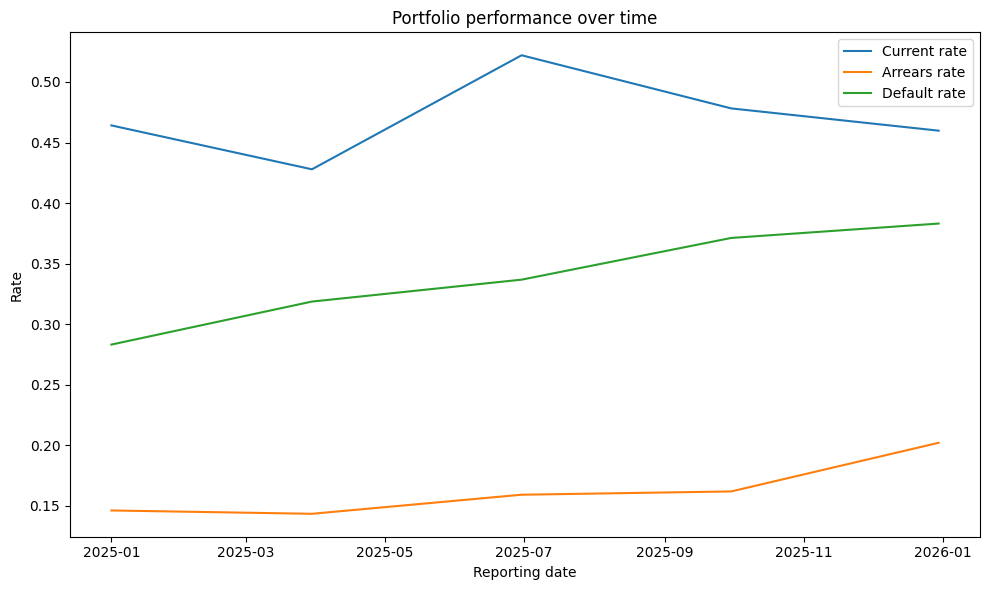

In [89]:
# Portfolio performance over time
plt.figure(figsize=(10, 6))
plt.plot(kpi["REPORTING_DATE"], kpi["current_rate"], label="Current rate")
plt.plot(kpi["REPORTING_DATE"], kpi["arrears_rate"], label="Arrears rate")
plt.plot(kpi["REPORTING_DATE"], kpi["default_rate"], label="Default rate")
plt.title("Portfolio performance over time")
plt.xlabel("Reporting date")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_DIR / "portfolio_performance.png")


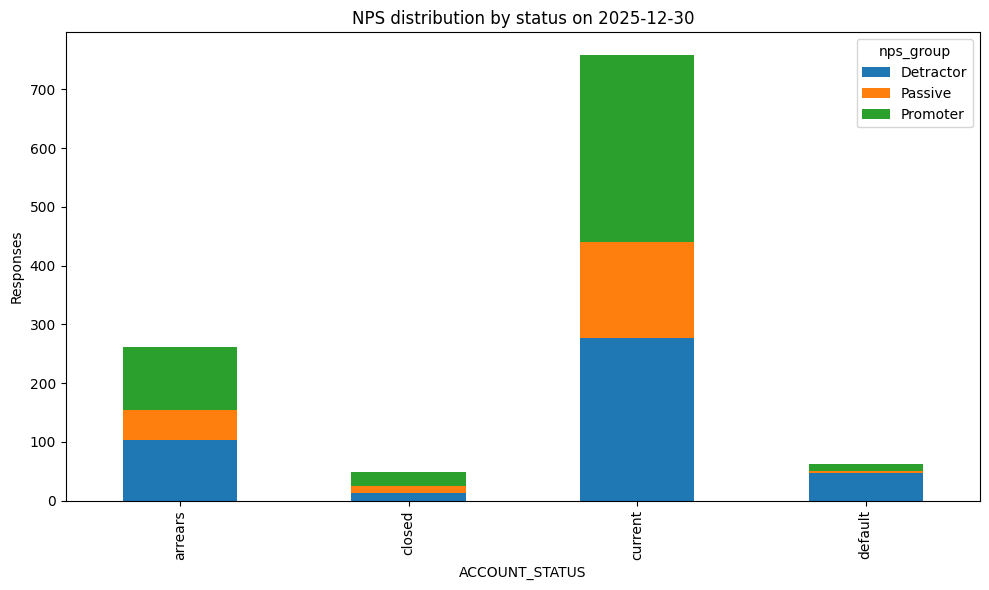

In [90]:
# NPS distribution by status on last snapshot
if not nps_status.empty:
    last_date = nps_status["REPORTING_DATE"].max()
    sub = nps_status[nps_status["REPORTING_DATE"] == last_date]
    if not sub.empty:
        pivot = sub.pivot(index="ACCOUNT_STATUS", columns="nps_group", values="responses").fillna(0)
        pivot = pivot.reindex(columns=["Detractor", "Passive", "Promoter", "Unknown"], fill_value=0)
        pivot[["Detractor", "Passive", "Promoter"]].plot(kind="bar", stacked=True, figsize=(10, 6))
        plt.title(f"NPS distribution by status on {last_date.date()}")
        plt.ylabel("Responses")
        plt.tight_layout()
        plt.savefig(OUT_DIR / "nps_by_status_last_snapshot.png")

In [91]:
print("Analysis complete. Outputs written to ./outputs")

Analysis complete. Outputs written to ./outputs


### 9) Vintage metrics (origination month) & Roll rates

In [92]:
# Assumption: CUSTOMER_AGE is days since sale; sale_date = REPORTING_DATE - CUSTOMER_AGE days
if "CUSTOMER_AGE" in credit.columns:
    # sale_date at each snapshot
    credit["SALE_DATE"] = credit["REPORTING_DATE"] - pd.to_timedelta(pd.to_numeric(credit["CUSTOMER_AGE"], errors="coerce"), unit="D")
    credit["ORIG_MONTH"] = credit["SALE_DATE"].dt.to_period("M").astype(str)
else:
    # Fallback if CUSTOMER_AGE missing
    credit["SALE_DATE"] = pd.NaT
    credit["ORIG_MONTH"] = np.nan


In [93]:
# Vintage metrics per snapshot x orig_month
vintage = (
    credit.groupby(["REPORTING_DATE", "ORIG_MONTH"])
    .agg(
        loans=("LOAN_ID", "nunique"),
        current_accounts=("ACCOUNT_STATUS", lambda s: (s == "current").sum()),
        arrears_accounts=("ACCOUNT_STATUS", lambda s: (s == "arrears").sum()),
        default_accounts=("ACCOUNT_STATUS", lambda s: (s == "default").sum()),
        closed_accounts=("ACCOUNT_STATUS", lambda s: (s == "closed").sum()),
    )
    .reset_index()
)


In [94]:
for col in ["current_accounts", "arrears_accounts", "default_accounts", "closed_accounts"]:
    vintage[col.replace("_accounts", "_rate")] = vintage[col] / vintage["loans"].replace({0: np.nan})

vintage.to_csv(OUT_DIR / "vintage_metrics.csv", index=False)


In [95]:
# Status transitions between consecutive snapshots per loan
credit_sorted = credit.sort_values(["LOAN_ID", "REPORTING_DATE"]).copy()
credit_sorted["rn"] = credit_sorted.groupby("LOAN_ID").cumcount() + 1

prev = credit_sorted.copy()
curr = credit_sorted.copy()
prev = prev.rename(columns={
    "REPORTING_DATE": "PREV_DATE",
    "ACCOUNT_STATUS": "PREV_STATUS",
    "rn": "PREV_RN",
})
curr = curr.rename(columns={
    "REPORTING_DATE": "CURR_DATE",
    "ACCOUNT_STATUS": "CURR_STATUS",
    "rn": "CURR_RN",
})



In [96]:
paired = curr.merge(prev[["LOAN_ID", "PREV_DATE", "PREV_STATUS", "PREV_RN"]],
                    on="LOAN_ID", how="left")
paired = paired[paired["CURR_RN"] == paired["PREV_RN"] + 1]

transitions = (
    paired.groupby(["PREV_DATE", "CURR_DATE", "PREV_STATUS", "CURR_STATUS"])
    .size().reset_index(name="transitions")
)
transitions.to_csv(OUT_DIR / "status_transitions.csv", index=False)


In [97]:
# Roll-rate matrix = transitions normalized by previous-status totals per (PREV_DATE -> CURR_DATE)
prev_totals = (
    transitions.groupby(["PREV_DATE", "CURR_DATE", "PREV_STATUS"])["transitions"]
    .sum().reset_index(name="prev_total")
)
roll = transitions.merge(prev_totals, on=["PREV_DATE", "CURR_DATE", "PREV_STATUS"], how="left")
roll["roll_rate"] = roll["transitions"] / roll["prev_total"].replace({0: np.nan})
roll.to_csv(OUT_DIR / "roll_rates.csv", index=False)


In [98]:
print("Vintage metrics (vintage_metrics.csv), transitions (status_transitions.csv), and roll rates (roll_rates.csv) written to ./outputs")

Vintage metrics (vintage_metrics.csv), transitions (status_transitions.csv), and roll rates (roll_rates.csv) written to ./outputs
